# Embedding demo

### simplified two-tower embedding

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import zipfile
import urllib.request
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Step 1: Download and extract the dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
urllib.request.urlretrieve(url, '../../../data/.local/ml-100k.zip')
# with zipfile.ZipFile('../../../data/.local/ml-100k.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

# Step 2: Load and preprocess data
# Load ratings data into pandas DataFrame
ratings = pd.read_csv('../../../data/.local/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings.drop(columns=['timestamp'], inplace=True)

# Load user data
users = pd.read_csv('../../../data/.local/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.drop(columns=['occupation', 'zip_code'], inplace=True)

# Load item data
items = pd.read_csv('../../../data/.local/ml-100k/u.item', sep='|', encoding='latin-1', 
                    names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 
                           'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                           'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
items.drop(columns=['title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown'], inplace=True)

# Merge ratings with user and item data
ratings = ratings.merge(users, on='user_id').merge(items, on='item_id')

# One-hot encode categorical variables
ratings = pd.get_dummies(ratings, columns=['gender'])
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
ratings = pd.get_dummies(ratings, columns=genres)

# # Normalize numerical features
scaler = MinMaxScaler()
ratings['age'] = scaler.fit_transform(ratings[['age']])

# # Prepare input data
user_input = ratings['user_id'].values
item_input = ratings['item_id'].values
user_features = ratings[['age', 'gender_F', 'gender_M']].values

# user_features

In [3]:
ratings.columns

Index(['user_id', 'item_id', 'rating', 'age', 'gender_F', 'gender_M',
       'Action_0', 'Action_1', 'Adventure_0', 'Adventure_1', 'Animation_0',
       'Animation_1', 'Children_0', 'Children_1', 'Comedy_0', 'Comedy_1',
       'Crime_0', 'Crime_1', 'Documentary_0', 'Documentary_1', 'Drama_0',
       'Drama_1', 'Fantasy_0', 'Fantasy_1', 'Film-Noir_0', 'Film-Noir_1',
       'Horror_0', 'Horror_1', 'Musical_0', 'Musical_1', 'Mystery_0',
       'Mystery_1', 'Romance_0', 'Romance_1', 'Sci-Fi_0', 'Sci-Fi_1',
       'Thriller_0', 'Thriller_1', 'War_0', 'War_1', 'Western_0', 'Western_1'],
      dtype='object')

In [4]:
ratings

,user_id,item_id,rating,age,gender_F,gender_M,Action_0,Action_1,Adventure_0,Adventure_1,...,Romance_0,Romance_1,Sci-Fi_0,Sci-Fi_1,Thriller_0,Thriller_1,War_0,War_1,Western_0,Western_1
0,196,242,3,0.636364,False,True,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False
1,305,242,5,0.242424,False,True,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False
2,6,242,4,0.530303,False,True,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False
3,234,242,4,0.803030,False,True,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False
4,63,242,3,0.363636,False,True,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,863,1679,3,0.151515,False,True,True,False,True,False,...,False,True,True,False,False,True,True,False,True,False
99996,863,1678,1,0.151515,False,True,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False
99997,863,1680,2,0.151515,False,True,True,False,True,False,...,False,True,True,False,True,False,True,False,True,False
99998,896,1681,3,0.318182,False,True,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False


In [5]:
ratings.columns

Index(['user_id', 'item_id', 'rating', 'age', 'gender_F', 'gender_M',
       'Action_0', 'Action_1', 'Adventure_0', 'Adventure_1', 'Animation_0',
       'Animation_1', 'Children_0', 'Children_1', 'Comedy_0', 'Comedy_1',
       'Crime_0', 'Crime_1', 'Documentary_0', 'Documentary_1', 'Drama_0',
       'Drama_1', 'Fantasy_0', 'Fantasy_1', 'Film-Noir_0', 'Film-Noir_1',
       'Horror_0', 'Horror_1', 'Musical_0', 'Musical_1', 'Mystery_0',
       'Mystery_1', 'Romance_0', 'Romance_1', 'Sci-Fi_0', 'Sci-Fi_1',
       'Thriller_0', 'Thriller_1', 'War_0', 'War_1', 'Western_0', 'Western_1'],
      dtype='object')

In [6]:

# item_features = ratings[['Action_0', 'Action_1', 'Adventure_0', 'Adventure_1', 'Animation_0',
#        'Animation_1', 'Children_0', 'Children_1', 'Comedy_0', 'Comedy_1',
#        'Crime_0', 'Crime_1', 'Documentary_0', 'Documentary_1', 'Drama_0',
#        'Drama_1', 'Fantasy_0', 'Fantasy_1', 'Film-Noir_0', 'Film-Noir_1',
#        'Horror_0', 'Horror_1', 'Musical_0', 'Musical_1', 'Mystery_0',
#        'Mystery_1', 'Romance_0', 'Romance_1', 'Sci-Fi_0', 'Sci-Fi_1',
#        'Thriller_0', 'Thriller_1', 'War_0', 'War_1', 'Western_0', 'Western_1']].values
item_features = ratings[ratings.columns.difference(['user_id', 'item_id', 'rating', 'age', 'gender_F', 'gender_M'])].values

ratings_input = ratings['rating'].values


# Ensure all input arrays are of type float32
user_features = user_features.astype(np.float32)
item_features = item_features.astype(np.float32)
ratings_input = ratings_input.astype(np.float32)

In [7]:

# Split data into training and testing sets
(user_train, user_test, item_train, item_test, user_features_train, user_features_test, 
 item_features_train, item_features_test, ratings_train, ratings_test) = train_test_split(
    user_input, item_input, user_features, item_features, ratings_input, test_size=0.2, random_state=42)

# Step 3: Define the Two-Tower Embedding Model
num_users = ratings['user_id'].nunique()
num_items = ratings['item_id'].nunique()
embedding_dim = 8

# User tower
user_input_layer = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users+1, output_dim=embedding_dim, name='user_embedding')(user_input_layer)
user_vec = Flatten(name='user_flatten')(user_embedding)

user_features_input = Input(shape=(user_features_train.shape[1],), name='user_features_input')
user_features_dense = Dense(embedding_dim, activation='relu', name='user_features_dense')(user_features_input)

user_concatenated = Concatenate(name='user_concatenated')([user_vec, user_features_dense])

# Item tower
item_input_layer = Input(shape=(1,), name='item_input')
item_embedding = Embedding(input_dim=num_items+1, output_dim=embedding_dim, name='item_embedding')(item_input_layer)
item_vec = Flatten(name='item_flatten')(item_embedding)

item_features_input = Input(shape=(item_features_train.shape[1],), name='item_features_input')
item_features_dense = Dense(embedding_dim, activation='relu', name='item_features_dense')(item_features_input)

item_concatenated = Concatenate(name='item_concatenated')([item_vec, item_features_dense])

# Dot product to calculate similarity
dot_product = Dot(axes=1, name='dot_product')([user_concatenated, item_concatenated])

# Final model
model = Model(inputs=[user_input_layer, item_input_layer, user_features_input, item_features_input], outputs=dot_product)
model.compile(optimizer='adam', loss='mse')

# Step 4: Train the Model
model.fit([user_train, item_train, user_features_train, item_features_train], ratings_train, epochs=5, batch_size=64, verbose=1)

# Step 5: Evaluate the Model
# Make predictions on the test set
predictions = model.predict([user_test, item_test, user_features_test, item_features_test])

# Calculate evaluation metrics
mse = mean_squared_error(ratings_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/5


2024-05-28 19:49:05.642926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-28 19:49:05.643040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-28 19:49:05.788879: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-28 19:49:06.072000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 6s 5ms/step - loss: 1.6740
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1199
Epoch 3/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9680
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8828
Epoch 5/5
100/625 [===>..........................] - ETA: 0s

2024-05-28 19:49:33.911590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 0.9095777273178101
Root Mean Squared Error (RMSE): 0.953717827796936


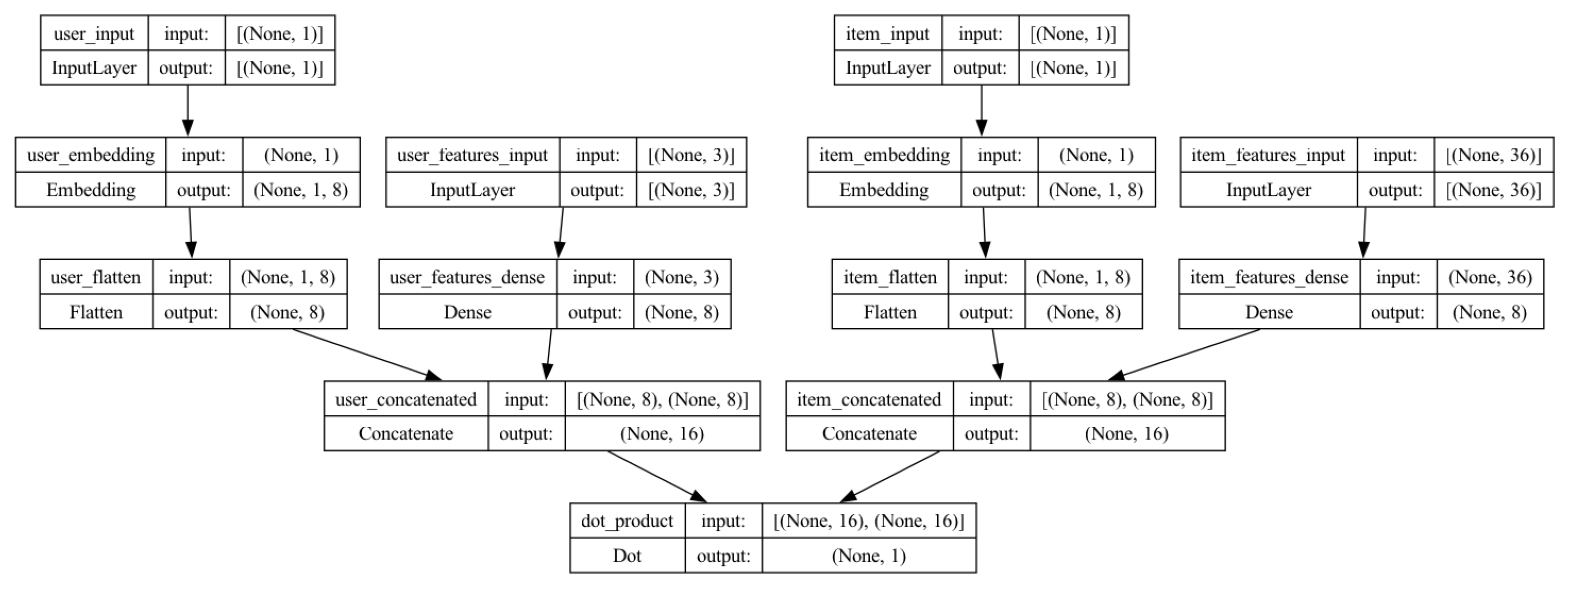

In [11]:
# Plot the model architecture
plot_file_path = '/Users/bichengwang/Documents/codes/python-notebook/src/tensorflow_lr/embedding_usages/two_tower_embedding_model_with_features.png'
plot_model(model, to_file=plot_file_path, show_shapes=True, show_layer_names=True)

# Display the model plot
img = mpimg.imread(plot_file_path)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

### simplified graph embedding

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example data
users = pd.DataFrame({
    'user_id': [1, 2, 3, 4],
    'user_age': [25, 34, 28, 22],
    'user_gender': ['M', 'F', 'M', 'F']
})

items = pd.DataFrame({
    'item_id': [1, 2, 3, 4],
    'movie_title': ['The Matrix', 'Titanic', 'The Godfather', 'The Shawshank Redemption'],
    'movie_genre': ['Sci-Fi', 'Romance', 'Crime', 'Drama']
})

ratings = pd.DataFrame({
    'user_id': [1, 1, 2, 2, 3, 3, 4, 4],
    'item_id': [1, 2, 2, 3, 1, 4, 2, 4],
    'rating': [5, 3, 4, 5, 4, 5, 3, 4]
})

# Encode categorical features
user_gender_encoder = LabelEncoder()
users['user_gender'] = user_gender_encoder.fit_transform(users['user_gender'])

# Normalize numerical features
age_scaler = MinMaxScaler()
users['user_age'] = age_scaler.fit_transform(users[['user_age']])

# Encode movie genre
movie_genre_encoder = LabelEncoder()
items['movie_genre'] = movie_genre_encoder.fit_transform(items['movie_genre'])

# Prepare input data
user_input = ratings['user_id'].values
item_input = ratings['item_id'].values
ratings_input = ratings['rating'].values

# Example model architecture
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

# User tower
user_input_layer = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=len(users)+1, output_dim=8)(user_input_layer)
user_vec = Flatten()(user_embedding)

# Item tower
item_input_layer = Input(shape=(1,), name='item_input')
item_embedding = Embedding(input_dim=len(items)+1, output_dim=8)(item_input_layer)
item_vec = Flatten()(item_embedding)

# Dot product to calculate similarity
dot_product = tf.reduce_sum(tf.multiply(user_vec, item_vec), axis=1)

# Final model
model = Model(inputs=[user_input_layer, item_input_layer], outputs=dot_product)
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit([user_input, item_input], ratings_input, epochs=5, batch_size=2)

# Summary of the model
model.summary()


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-05-28 18:36:10.166251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-28 18:36:10.166377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-05-28 18:36:10.702792: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-28 18:36:10.897086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 10ms/step - loss: 17.6313
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 17.6264
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 17.6225
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 17.6186
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 17.6141
Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 17.6093
Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 17.6049
Epoch 8/10
4/4 [==============================] - 0s 3ms/step - loss: 17.6003
Epoch 9/10
4/4 [==============================] - 0s 6ms/step - loss: 17.5957
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 17.5898
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (Inp

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dot
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import zipfile
import urllib.request


# Example data
# ratings = pd.DataFrame({
#     'user_id': [1, 1, 2, 2, 3, 3, 4, 4],
#     'item_id': [1, 2, 2, 3, 1, 4, 2, 4],
#     'rating': [5, 3, 4, 5, 4, 5, 3, 4]
# })

# # Prepare input data
# user_input = ratings['user_id'].values
# item_input = ratings['item_id'].values
# ratings_input = ratings['rating'].values

# # Model parameters
# num_users = ratings['user_id'].nunique()
# num_items = ratings['item_id'].nunique()


# Download and extract the dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
urllib.request.urlretrieve(url, '../../../data/.local/ml-100k.zip')
with zipfile.ZipFile('../../../data/.local/ml-100k.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Load data into pandas DataFrame
ratings = pd.read_csv('../../../data/.local/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings.drop(columns=['timestamp'], inplace=True)

# Prepare input data
user_input = ratings['user_id'].values
item_input = ratings['item_id'].values
ratings_input = ratings['rating'].values

# Split data into training and testing sets
user_train, user_test, item_train, item_test, ratings_train, ratings_test = train_test_split(
    user_input, item_input, ratings_input, test_size=0.2, random_state=42)

num_users = ratings['user_id'].nunique()
num_items = ratings['item_id'].nunique()

embedding_dim = 8

# User tower
user_input_layer = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users+1, output_dim=embedding_dim, name='user_embedding')(user_input_layer)
user_vec = Flatten(name='user_flatten')(user_embedding)

# Item tower
item_input_layer = Input(shape=(1,), name='item_input')
item_embedding = Embedding(input_dim=num_items+1, output_dim=embedding_dim, name='item_embedding')(item_input_layer)
item_vec = Flatten(name='item_flatten')(item_embedding)

# Dot product to calculate similarity
dot_product = Dot(axes=1, name='dot_product')([user_vec, item_vec])

# Final model
model = Model(inputs=[user_input_layer, item_input_layer], outputs=dot_product)
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit([user_train, item_train], ratings_train, epochs=5, batch_size=64, verbose=1)


# Summary of the model
model.summary()

# Make predictions on the test set
predictions = model.predict([user_test, item_test])

# Evaluate the model
mse = mean_squared_error(ratings_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Epoch 1/10
   4/1250 [..............................] - ETA: 23s - loss: 13.9053 

2024-05-28 18:58:40.736097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 5s 4ms/step - loss: 12.0647
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 3.7053
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5645
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1455
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9979
Epoch 6/10
1250/1250 [==============================] - 4s 4ms/step - loss: 0.9342
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9033
Epoch 8/10
1250/1250 [==============================] - 4s 4ms/step - loss: 0.8857
Epoch 9/10
1250/1250 [==============================] - 4s 4ms/step - loss: 0.8748
Epoch 10/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8663
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #   

2024-05-28 18:59:26.398761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 1s 1ms/step
Mean Squared Error (MSE): 0.9120335695677148
Root Mean Squared Error (RMSE): 0.955004486674128


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dot
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import zipfile
import urllib.request

# Download and extract the dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
urllib.request.urlretrieve(url, '../../../data/.local/ml-100k.zip')
with zipfile.ZipFile('../../../data/.local/ml-100k.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Load data into pandas DataFrame
ratings = pd.read_csv('../../../data/.local/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings.drop(columns=['timestamp'], inplace=True)

# Prepare input data
user_input = ratings['user_id'].values
item_input = ratings['item_id'].values
ratings_input = ratings['rating'].values

# Split data into training and testing sets
user_train, user_test, item_train, item_test, ratings_train, ratings_test = train_test_split(
    user_input, item_input, ratings_input, test_size=0.2, random_state=42)

# Model parameters
num_users = ratings['user_id'].nunique()
num_items = ratings['item_id'].nunique()
embedding_dim = 8

# User tower
user_input_layer = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users+1, output_dim=embedding_dim, name='user_embedding')(user_input_layer)
user_vec = Flatten(name='user_flatten')(user_embedding)

# Item tower
item_input_layer = Input(shape=(1,), name='item_input')
item_embedding = Embedding(input_dim=num_items+1, output_dim=embedding_dim, name='item_embedding')(item_input_layer)
item_vec = Flatten(name='item_flatten')(item_embedding)

# Dot product to calculate similarity
dot_product = Dot(axes=1, name='dot_product')([user_vec, item_vec])

# Final model
model = Model(inputs=[user_input_layer, item_input_layer], outputs=dot_product)
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit([user_train, item_train], ratings_train, epochs=5, batch_size=64, verbose=1)

# Make predictions on the test set
predictions = model.predict([user_test, item_test])

# Evaluate the model
mse = mean_squared_error(ratings_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Epoch 1/10
   5/1250 [..............................] - ETA: 16s - loss: 13.5537 

2024-05-28 18:43:18.351864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 5s 3ms/step - loss: 11.9528
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 3.5396
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5267
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1334
Epoch 5/10
1250/1250 [==============================] - 4s 4ms/step - loss: 0.9943
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9358
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9068
Epoch 8/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8913
Epoch 9/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8819
Epoch 10/10
142/625 [=====>........................] - ETA: 0s

2024-05-28 18:44:02.913787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 1s 1ms/step
Mean Squared Error (MSE): 0.9169867498032821
Root Mean Squared Error (RMSE): 0.9575942511331624


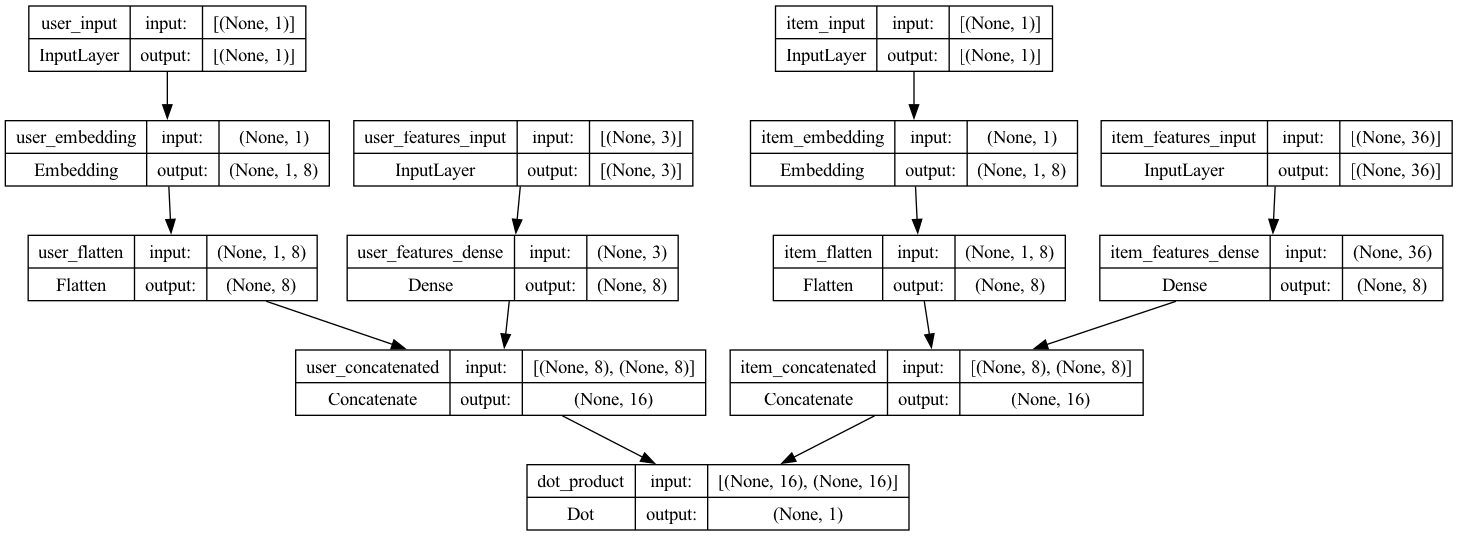

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Plot the model
plot_model(model, to_file='./two_tower_embedding_model.png', show_shapes=True, show_layer_names=True)

# Display the model plot
Image(filename='./two_tower_embedding_model.png')